# Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import time
import math
import matplotlib as mp
import scipy as sp
import pylab as py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd

from ipynb.fs.full.Neutron_Star_SPH_sph import W, gradW, getPairwiseSeparations, getDensity
from ipynb.fs.full.Neutron_Star_SPH_eos import EOS, rho_NS
from ipynb.fs.full.Neutron_Star_SPH_NS import NS, getAcc
from ipynb.fs.full.NS_dynamics import get_r,grav_force,new_com,leapfrogintegrate

# MAIN

To do: 
- smoothing length should depend on density of particles at that location, not just a constant
- update getPressure.

## Initialize star objects

In [35]:
# Initialize Neutron Star Objects
M1 = 0.5
M2 = 0.5
R1 = 1
R2 = 1

eos = EOS('standard')
star_1 = NS("star_1", eos,M1,R1)
star_2 = NS("star_2", eos,M2,R2)

star1_com = [-10,-10,-10] # km 
star2_com = [-100,-1,1] # km 
star1_com_velocity = [10,20,30] # km/s 
star2_com_velocity = [0,40,0] # km/s

star_1.move_com(star1_com) # move the stars to their initial locations
star_2.move_com(star2_com) 

r = get_r(star1_com,star2_com) # gravitational force
f = grav_force(M1, M2,r)

# =================== Simulation Specs for the animation ================== # 
end_time = 20 # amount of time that the simulation runs (seconds)
time_per_timestep = 1 # the amount of time, in seconds, that goes by in 1 timestep.
EndTimeStep = end_time/time_per_timestep # number of timesteps of the animation
print("sucessfully initialized stars!")

-------success!
 
STAR OBJECT. Name: 'star_1', Mass: 0.5 SMs, Radius: 1 km 

-------success!
 
STAR OBJECT. Name: 'star_2', Mass: 0.5 SMs, Radius: 1 km 

sucessfully initialized stars!


## Determine the location of the COM of the stars as they orbit.

In [13]:
"""
This is the part that is not right, but the goalof this block is 
to produce two numpy arrays containing the center of mass positions. 

COM_DATA_star1 = numpy array containing star 1 center of mass positions
COM_DATA_star2 = numpy array containing star 2 center of mass positions

"""
# ==============================================================
# time array
time = np.arange(0, 480, 0.5)

# body m1 initial conditions
m1 = M1*2e30  # mass (kg)
r10 = np.array(star1_com)  # initial position (km)
v10 = np.array(star1_com_velocity)  # initial velocity (km/s)

# body m2 initial conditions
m2 = M2*2e30  # mass (kg)
r20 = np.array(star2_com)  # initial position (km)
v20 = np.array(star2_com_velocity)  # initial velocity (km/s)
# ==============================================================
# propagate state
N_ = 1000 # timesteps
dt_ = 0.1 # seconds

# simulation results
x1,x2,y1,y2,z1,z2,vx1,vx2,vy1,vy2,vz1,vz2 = leapfrogintegrate(0,0, r10, r20, v10, v20, m1, m2,N=N_,dt = dt_)

COM_DATA_star1 = np.concatenate((x1,y1,z1))
COM_DATA_star2 = np.concatenate((x2,y2,z2))

# Animation
##### This code block takes in a list of center of mass positions of each star at each timestep and saves an animation of the star's motion.

Sucessfully updated and stored star locations.

Sucessfully made plotting dataframe: 

       time          x          y          z
0       0.0  -9.811125  -9.997694  -9.761977
1       0.0  -9.477119 -10.080386 -10.080383
2       0.0  -9.472766  -9.738088 -10.175299
3       0.0  -9.781733 -10.112019 -10.167895
4       0.0  -9.916831 -10.656661 -10.593383
...     ...        ...        ...        ...
12595  20.0 -99.359552  -0.812927   0.881141
12596  20.0 -99.787001  -0.637981   1.211460
12597  20.0 -99.862110  -0.628259   1.456643
12598  20.0 -99.560115  -0.788062   0.921937
12599  20.0 -99.941302  -0.556804   0.709191

[12600 rows x 4 columns]


/Users/alexastewart/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


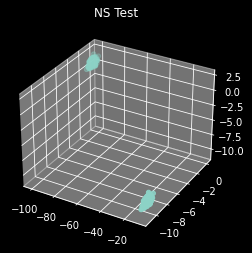

In [44]:
# ============== Takes in a list of center of mass positions ============== #

star1_list = [star1_com for i in range(int(EndTimeStep))] # Todo !!!  This is a placeholder value and should come from the above block
star2_list = [star2_com for i in range(int(EndTimeStep))] # Todo !!!

if len(star1_list) != int(EndTimeStep):
    raise ValueError("List of center of mass positions for the first star does not match number of timesteps")
if len(star2_list) != int(EndTimeStep):
    raise ValueError("List of center of mass positions for the second star does not match number of timesteps")
if len(star1_list[0]) != 3:
    raise ValueError("Center of mass coordinates must have dimension 3")
if len(star2_list[0]) != 3:
    raise ValueError("Center of mass coordinates must have dimension 3")
# ========================================================================= # 
# The next few blocks creates an animation with the two stars in 3D.

star1_pos = star_1.getPosition()
star2_pos = star_2.getPosition()
a = np.concatenate((star1_pos,star2_pos)) # start off array of points with just the initial star locations.

# Update the Neutron Star points locations...
for t in range(int(EndTimeStep)): # for every timestep in the simulation
        # -- 0. Update the location of the center of mass -- #
    star_1.move_com(star1_com) # move the stars to their COM locations
    star_2.move_com(star2_com)
        # -- 1. update the force on the center of mass -- #
    star_1.modify_com_force(f) # The center of masses of the points experience increasing forces in opposite directions.
    star_2.modify_com_force([-1*i for i in f]) # 
        # -- 2. update the positions, velocities, and accelerations for this timestep. -- #
    pos1 = star_1.getPosition() # just updating the point locations for now.
    pos2 = star_2.getPosition()
    ### Output Current Star Point positions to pandas dataframe for plotting
    a = np.concatenate((a,pos1)) # add the new star positions for this timestep to the outputed data array for star 1
    a = np.concatenate((a,pos2))# add the new star positions for this timestep to the outputed data array for star 2
    
print("Sucessfully updated and stored star locations.")

num_points1 = star_1.num_points 
num_points2 = star_2.num_points
points_per_timestep = num_points1 + num_points2 # we need to assign the first set of points, (num_points1 + num_points2) points to the same timestep in the movie

points_count = len(a) # Total number of points in the entire simulation
t = np.array([np.ones(points_per_timestep)*i for i in range(int(points_count/points_per_timestep))]).flatten() # an array counting from 0 to 19. Each number repeats 100 times.
df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})
print("\nSucessfully made plotting dataframe: \n")
print(df)

def update_graph(num):
    data=df[df['time']==num]
    graph._offsets3d = (data.x, data.y, data.z)
    title.set_text('NS Test, time={}'.format(num))
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('NS Test')
data=df[df['time']==0]
graph = ax.scatter(data.x, data.y, data.z)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, int(EndTimeStep), interval=10, blit=False)
plt.show()

In [45]:
ani.save("ns-test-.mp4")
print("Saved animation.")

Saved animation.
